## Import Library

In [24]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [25]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pemisahan Dataset dan Augmentasi Data



In [26]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train'
val_dir = '/content/drive/MyDrive/PI/valid'
test_dir = '/content/drive/MyDrive/PI/test'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

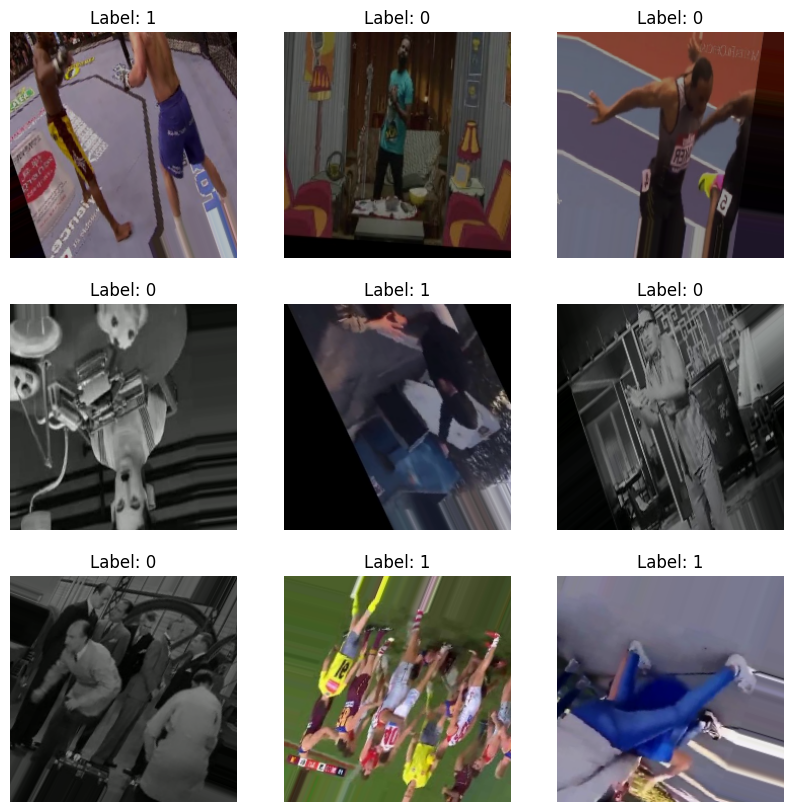

In [27]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [28]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze 20
for layer in base_model.layers[:40]:
    layer.trainable = False
for layer in base_model.layers[40:]:
    layer.trainable = True

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'NoMCLAHE_Freeze40_0.0001.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [29]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.5486 - loss: 1.4581
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to NoMCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 703ms/step - accuracy: 0.5491 - loss: 1.4572 - val_accuracy: 0.5000 - val_loss: 1.1581
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.6453 - loss: 1.2168
Epoch 2: val_accuracy improved from 0.50000 to 0.68409, saving model to NoMCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 722ms/step - accuracy: 0.6457 - loss: 1.2161 - val_accuracy: 0.6841 - val_loss: 1.0907
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.6948 - loss: 1.1492
Epoch 3: val_accuracy improved from 0.68409 to 0.78636, saving model to NoMCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 655ms/step - accuracy: 0.6945 - loss: 1.1492 - val_accuracy: 0.7864 - val_loss: 1.0299
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.6760 - loss: 1.1306
Epoch 4: val_accuracy improved from 0.78636 to 0.80227, saving model to NoMCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 652ms/step - accuracy: 0.6763 - loss: 1.1299 - val_accuracy: 0.8023 - val_loss: 0.9765
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.7004 - loss: 1.0813
Epoch 5: val_accuracy did not improve from 0.80227
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 675ms/step - accuracy: 0.7005 - loss: 1.0804 - val_accuracy: 0.7705 - val_loss: 0.9239
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.7471 - loss: 0.9905
Epoch 6: val_accuracy did not improve from 0.80227
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 657ms/step - accuracy: 0.7468 - loss: 0.9906 - val_accuracy: 0.7591 - val_loss: 0.8771
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.7268 - loss: 0.9693
Epoch 7: val_accuracy did not improve from 0.80227
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 710ms/step - accuracy: 0.7270 - loss: 0.9695 - val_accuracy: 0.7841 - val_loss: 0.8318
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.7490 - loss: 0.9156
Epoch 8: val_accuracy improved 

49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 650ms/step - accuracy: 0.7492 - loss: 0.9158 - val_accuracy: 0.8159 - val_loss: 0.7776
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.7553 - loss: 0.9150
Epoch 9: val_accuracy improved from 0.81591 to 0.82045, saving model to NoMCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 680ms/step - accuracy: 0.7552 - loss: 0.9151 - val_accuracy: 0.8205 - val_loss: 0.7532
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.7644 - loss: 0.9083
Epoch 10: val_accuracy improved from 0.82045 to 0.82727, saving model to NoMCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 663ms/step - accuracy: 0.7642 - loss: 0.9085 - val_accuracy: 0.8273 - val_loss: 0.7293
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.7510 - loss: 0.9056
Epoch 11: val_accuracy improved from 0.82727 to 0.83864, saving model to NoMCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 719ms/step - accuracy: 0.7510 - loss: 0.9053 - val_accuracy: 0.8386 - val_loss: 0.7095
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.7689 - loss: 0.8633
Epoch 12: val_accuracy did not improve from 0.83864
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 661ms/step - accuracy: 0.7687 - loss: 0.8637 - val_accuracy: 0.8341 - val_loss: 0.6904
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.7584 - loss: 0.8743
Epoch 13: val_accuracy improved from 0.83864 to 0.84545, saving model to NoMCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 687ms/step - accuracy: 0.7583 - loss: 0.8747 - val_accuracy: 0.8455 - val_loss: 0.6706
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.7590 - loss: 0.8785
Epoch 14: val_accuracy did not improve from 0.84545
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 676ms/step - accuracy: 0.7593 - loss: 0.8784 - val_accuracy: 0.8409 - val_loss: 0.6708
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.7856 - loss: 0.8253
Epoch 15: val_accuracy did not improve from 0.84545
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 676ms/step - accuracy: 0.7854 - loss: 0.8258 - val_accuracy: 0.8364 - val_loss: 0.6780
Epoch 16/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.7855 - loss: 0.8282
Epoch 16: val_accuracy did not improve from 0.84545
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 671ms/step - accuracy: 0.7855 - loss: 0.8284 - val_accuracy: 0.8341 - val_loss: 0.6697
Epoch 17/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.7809 - loss: 0.8329
Epoch 17: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 675ms/step - accuracy: 0.7724 - loss: 0.8424 - val_accuracy: 0.8591 - val_loss: 0.6348
Epoch 20/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.7900 - loss: 0.7873
Epoch 20: val_accuracy did not improve from 0.85909
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 667ms/step - accuracy: 0.7899 - loss: 0.7876 - val_accuracy: 0.8523 - val_loss: 0.6564
Epoch 21/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.8034 - loss: 0.7808
Epoch 21: val_accuracy did not improve from 0.85909
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 667ms/step - accuracy: 0.8033 - loss: 0.7811 - val_accuracy: 0.8477 - val_loss: 0.6614
Epoch 22/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.7927 - loss: 0.8111
Epoch 22: val_accuracy did not improve from 0.85909
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 661ms/step - accuracy: 0.7926 - loss: 0.8114 - val_accuracy: 0.8455 - val_loss: 0.6498
Epoch 23/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.8290 - loss: 0.7327
Epoch 23: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 679ms/step - accuracy: 0.8204 - loss: 0.7183 - val_accuracy: 0.8705 - val_loss: 0.6021
Epoch 30/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.8082 - loss: 0.7455
Epoch 30: val_accuracy did not improve from 0.87045
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 670ms/step - accuracy: 0.8081 - loss: 0.7457 - val_accuracy: 0.8705 - val_loss: 0.5966
Epoch 31/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.8240 - loss: 0.7021
Epoch 31: val_accuracy did not improve from 0.87045
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 722ms/step - accuracy: 0.8237 - loss: 0.7028 - val_accuracy: 0.8614 - val_loss: 0.5995
Epoch 32/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.7946 - loss: 0.7650
Epoch 32: val_accuracy did not improve from 0.87045
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 663ms/step - accuracy: 0.7947 - loss: 0.7646 - val_accuracy: 0.8568 - val_loss: 0.6064
Epoch 33/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.8131 - loss: 0.7080
Epoch 33: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 685ms/step - accuracy: 0.8095 - loss: 0.7073 - val_accuracy: 0.8727 - val_loss: 0.5812
Epoch 37/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.8021 - loss: 0.7330
Epoch 37: val_accuracy did not improve from 0.87273
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 704ms/step - accuracy: 0.8023 - loss: 0.7332 - val_accuracy: 0.8682 - val_loss: 0.5854
Epoch 38/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.8113 - loss: 0.7422
Epoch 38: val_accuracy did not improve from 0.87273
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 683ms/step - accuracy: 0.8111 - loss: 0.7421 - val_accuracy: 0.8659 - val_loss: 0.5897
Epoch 39/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.8189 - loss: 0.6994
Epoch 39: val_accuracy did not improve from 0.87273
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 702ms/step - accuracy: 0.8189 - loss: 0.6995 - val_accuracy: 0.8500 - val_loss: 0.6144
Epoch 40/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.8180 - loss: 0.6940
Epoch 40: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 715ms/step - accuracy: 0.8209 - loss: 0.7068 - val_accuracy: 0.8750 - val_loss: 0.5667
Epoch 42/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.8083 - loss: 0.7250
Epoch 42: val_accuracy did not improve from 0.87500
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 704ms/step - accuracy: 0.8085 - loss: 0.7247 - val_accuracy: 0.8636 - val_loss: 0.5773
Epoch 43/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.8221 - loss: 0.7110
Epoch 43: val_accuracy did not improve from 0.87500
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 677ms/step - accuracy: 0.8222 - loss: 0.7106 - val_accuracy: 0.8682 - val_loss: 0.5859
Epoch 44/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.8330 - loss: 0.6840
Epoch 44: val_accuracy did not improve from 0.87500
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 705ms/step - accuracy: 0.8329 - loss: 0.6841 - val_accuracy: 0.8705 - val_loss: 0.5775
Epoch 45/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.8173 - loss: 0.6918
Epoch 45: val_accuracy i

49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 687ms/step - accuracy: 0.8173 - loss: 0.6918 - val_accuracy: 0.8773 - val_loss: 0.5554
Epoch 46/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.8055 - loss: 0.7072
Epoch 46: val_accuracy improved from 0.87727 to 0.88182, saving model to NoMCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 699ms/step - accuracy: 0.8056 - loss: 0.7071 - val_accuracy: 0.8818 - val_loss: 0.5508
Epoch 47/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.8490 - loss: 0.6465
Epoch 47: val_accuracy improved from 0.88182 to 0.88636, saving model to NoMCLAHE_Freeze40_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 692ms/step - accuracy: 0.8487 - loss: 0.6470 - val_accuracy: 0.8864 - val_loss: 0.5575
Epoch 48/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.8037 - loss: 0.7120
Epoch 48: val_accuracy did not improve from 0.88636
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 688ms/step - accuracy: 0.8039 - loss: 0.7116 - val_accuracy: 0.8795 - val_loss: 0.5540
Epoch 49/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.8275 - loss: 0.6723
Epoch 49: val_accuracy did not improve from 0.88636
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 676ms/step - accuracy: 0.8277 - loss: 0.6718 - val_accuracy: 0.8864 - val_loss: 0.5356
Epoch 50/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.8228 - loss: 0.6973
Epoch 50: val_accuracy did not improve from 0.88636
49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 737ms/step - accuracy: 0.8230 - loss: 0.6968 - val_accuracy: 0.8750 - val_loss: 0.5409


## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.8468 - loss: 0.5934
Validation Loss: 0.5408604145050049
Validation Accuracy: 0.875


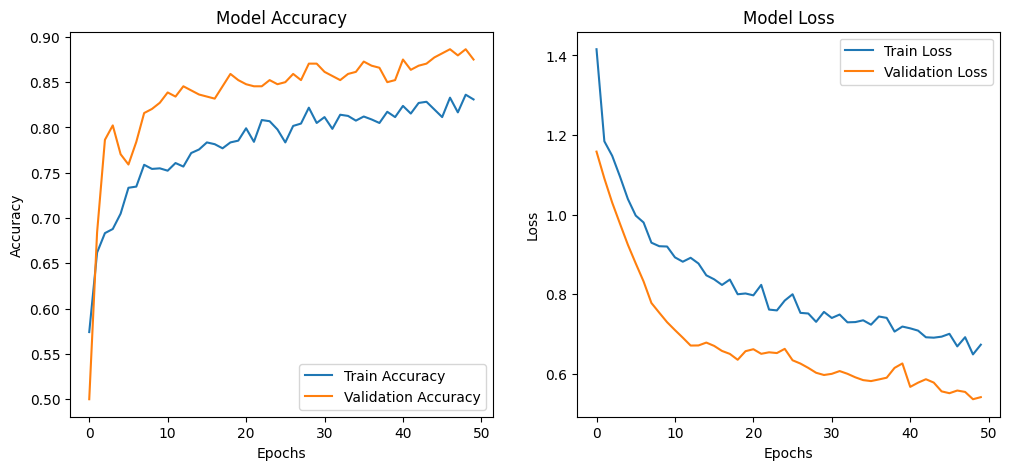

In [30]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [31]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('NoMCLAHE_Freeze40_0.0001.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.8454 - loss: 0.6829
Test Accuracy : 90.09%
Test Loss     : 0.554


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step


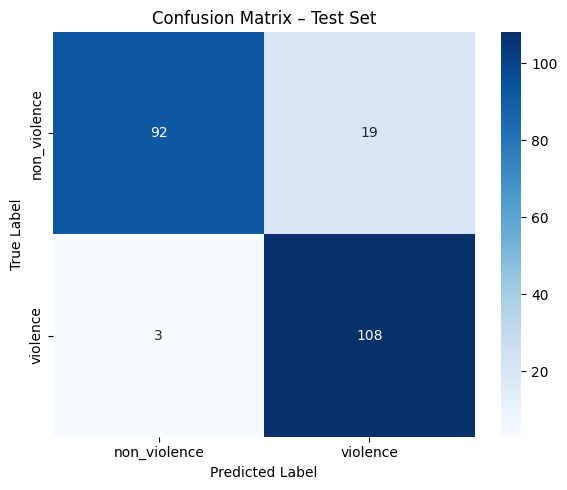


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.97      0.83      0.89       111
    violence       0.85      0.97      0.91       111

    accuracy                           0.90       222
   macro avg       0.91      0.90      0.90       222
weighted avg       0.91      0.90      0.90       222



In [32]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))